# Set Up

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.signal import sepfir2d
import folium
import random
import math
%matplotlib inline

from os import path, getcwd
from glob import glob

code_dir = getcwd()
data_dir = path.expanduser('~/data/workshop-content18/3-snc/data/')

ais_pathnames = glob(data_dir + '*.txt')
ais_basenames = [path.basename(pn) for pn in ais_pathnames]

delta_cur_basename = next(bn for bn in ais_basenames if 'Deltaport_Current' in bn)
delta_his_basename = next(bn for bn in ais_basenames if 'Deltaport_History' in bn)

max_rows=int(3e6)
delta_cur = pd.read_csv(
    data_dir + delta_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

In [157]:
if delta_cur.isna().iloc[-1,:].sum() > 10:
    delta_cur = delta_cur.iloc[:-1, :]

In [158]:
delta_cur.UserID = delta_cur.UserID.astype('category')

In [159]:
delta_cur = delta_cur.loc[delta_cur.Latitude < 80]

In [160]:
nPoints_by_UserID = pd.value_counts(delta_cur.UserID)

In [161]:
nPoints_threshold = 1000
userID_allowed = nPoints_by_UserID.index[nPoints_by_UserID > nPoints_threshold]
userID_allowed.values.remove_unused_categories(inplace=True)

In [162]:
delta_cur = delta_cur.loc[delta_cur.UserID.apply(lambda x: x in userID_allowed.values)]

In [163]:
ReceivedDate = delta_cur.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()

,ReceivedTime
2013-10-23,276045
2013-10-29,267727
2013-10-22,266404
2013-10-27,259420
2013-10-28,253972
2013-10-26,238035
2013-10-30,237996
2013-10-31,237442
2013-10-25,220591
2013-10-24,196405


In [164]:
delta_cur['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)

In [165]:
sns.set(style="whitegrid", color_codes=True)

In [166]:
df_grp = delta_cur.groupby(['ReceivedDay', 'UserID'])

Let's plot records of ships just on the 22nd

In [167]:
delta_cur_22 = delta_cur.loc[delta_cur.ReceivedDay == 22, :]

# One Ship

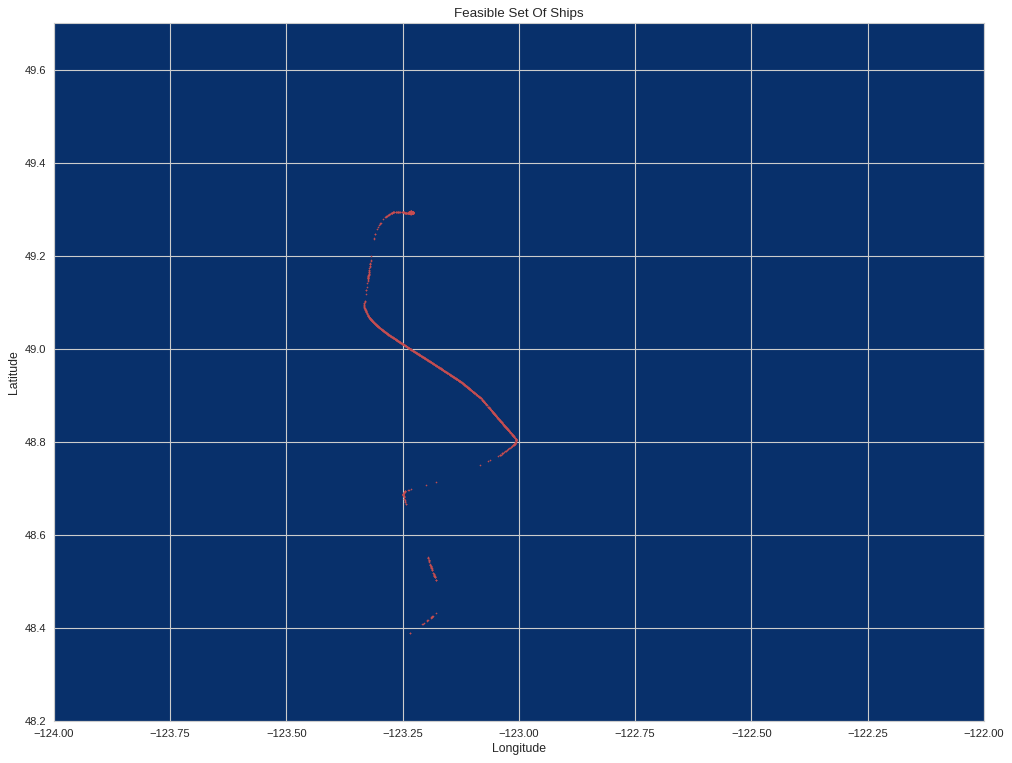

In [180]:
UserID_vc = pd.value_counts(delta_cur.UserID)
#i = random.randint(1,int(UserID_vc.size)) # 117
i = 182 # 95 # 59
#i = 117
ship = (delta_cur.loc[delta_cur.UserID == UserID_vc.index[i]])

xedges = np.load('xedges.dat')
yedges = np.load('yedges.dat')
H = np.load('FS.dat') # feasible set
H = sepfir2d(H, [1,2,3,5], [1,4,5,6])
H[H>0]=1
H = sepfir2d(H, [1,2,3,5], [1,4,5,6])
H[H>0]=1
H = sepfir2d(H, [1,1,1,1], [1,1,1,1])
H[H>0]=1
H = np.ones(H.shape)
H[1,1] = 0


x = list(ship.Longitude)
y = list(ship.Latitude)

fig = plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Feasible Set Of Ships")
plt.imshow(H, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.Blues)

plt.scatter(x,y, marker='.', color='r', s=5)

In [181]:
ps = list(zip(x,y)) # all points
butfirst = ps[1:] # all points but first
butlast = ps[:-1] # all points but last
lines = list(zip(butlast,butfirst)) # all directed line segments (ship goes from point one to point two)

In [182]:
def length(line):
    return math.sqrt((line[1][0] - line[0][0]) ** 2 + (line[1][0] - line[0][0]) ** 2)


Text(0.5,1,'Length of line intervals')

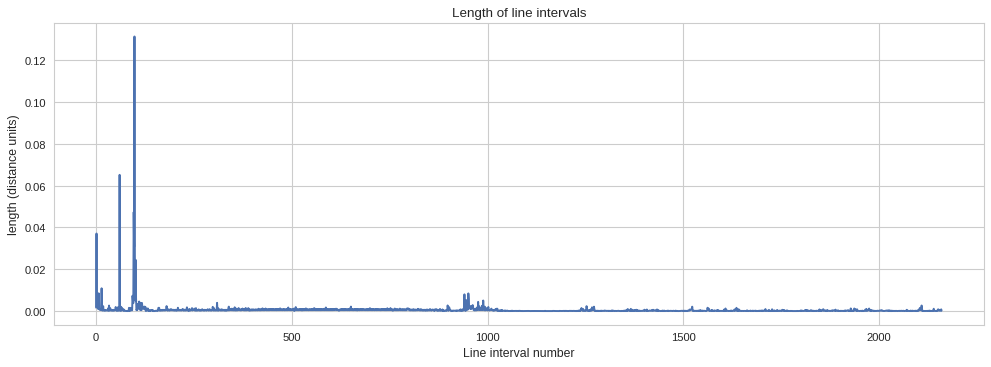

In [183]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([length(x) for x in lines])
plt.ylabel('length (distance units)')
plt.xlabel('Line interval number')
plt.title('Length of line intervals')

# Improving Path

In [211]:
FS = H
STEP = 0.01

NUM = 1000

START_X = -124
END_X = -122

START_Y = 48.2
END_Y = 49.7

dx = (END_X - START_X)/NUM
dy = (END_Y - START_Y)/NUM

# Point -> (Int, Int) or False
# get i,j indices in the feasible set from coordinates
def pos2ij(point):
    if point[0] < START_X or point[0] > END_X:
        return False
    if point[1] < START_Y or point[1] > END_Y:
        return False
    
    return (int((point[0] - START_X)/dx), int((point[1] - START_Y)/dy))

def ij2pos(ij):
    i = ij[0]
    j = ij[1]
    return (i*dx + START_X, j*dy + START_Y)

# Point -> Boolean
# produce true if point is in the feasible set
def isFeasible(point):
    if point[0] < 0 or point[0] >= NUM - 1:
        return False
    if point[1] < 0 or point[1] >= NUM - 1:
        return False
    
    return (FS[point[0], point[1]] > 0)

# Point, Point -> [Point] or False
def getPath(begin, end):
    # Convert to indices
    begin = pos2ij(begin)
    end = pos2ij(end)
    
    if not isFeasible(begin):
        for dx in range(-1,2):
            for dy in range(-1,2):
                if not isFeasible(begin) and isFeasible((begin[0]+dx,begin[1]+dy)):
                    begin = (begin[0]+dx,begin[1]+dy)
                    
        
    if not isFeasible(end):
        for dx in range(-1,2):
            for dy in range(-1,2):
                if not isFeasible(end) and isFeasible((end[0]+dx,end[1]+dy)):
                    begin = (end[0]+dx,end[1]+dy)
    
    visited = set() # ij's already visited
    todo = [(begin, ())] # ij's and path leading to them
    # WLE is (Point, [Point])
    # node and path
    
    while todo:
        (node, path) = todo.pop(0)
        if node == end:
            return path
        if node not in visited:
            visited.add(node)
            M = 10;
            if isFeasible((node[0]+M,node[1])):
                todo.append(((node[0]+M,node[1]), (node, *path)))
            if isFeasible((node[0]-M,node[1])):
                todo.append(((node[0]-M,node[1]), (node, *path)))
            if isFeasible((node[0],node[1]+M)):
                todo.append(((node[0],node[1]+M), (node, *path)))
            if isFeasible((node[0],node[1]-M)):
                todo.append(((node[0],node[1]-M), (node, *path)))
                
            todo.sort(key=lambda p: -math.hypot(p[0][0] - end[0], p[0][1] - end[1]))
    
    #return False
    return path

In [212]:
getPath(lines[98][0],lines[98][1])

((461, 362),
 (461, 352),
 (461, 342),
 (461, 332),
 (461, 322),
 (461, 312),
 (461, 302),
 (461, 292),
 (461, 282),
 (461, 272),
 (461, 262),
 (461, 252),
 (461, 242),
 (461, 232),
 (461, 222),
 (461, 212),
 (461, 202),
 (461, 192),
 (461, 182),
 (461, 172),
 (461, 162),
 (461, 152),
 (461, 142),
 (461, 132),
 (461, 122),
 (461, 112),
 (461, 102),
 (461, 92),
 (461, 82),
 (461, 72),
 (461, 62),
 (461, 52),
 (461, 42),
 (461, 32),
 (461, 22),
 (461, 12),
 (461, 2),
 (471, 2),
 (481, 2),
 (491, 2),
 (501, 2),
 (511, 2),
 (521, 2),
 (531, 2),
 (541, 2),
 (551, 2),
 (561, 2),
 (571, 2),
 (581, 2),
 (591, 2),
 (601, 2),
 (611, 2),
 (621, 2),
 (631, 2),
 (641, 2),
 (651, 2),
 (661, 2),
 (671, 2),
 (681, 2),
 (691, 2),
 (701, 2),
 (711, 2),
 (721, 2),
 (731, 2),
 (741, 2),
 (751, 2),
 (761, 2),
 (771, 2),
 (781, 2),
 (791, 2),
 (801, 2),
 (811, 2),
 (821, 2),
 (831, 2),
 (841, 2),
 (851, 2),
 (861, 2),
 (871, 2),
 (881, 2),
 (891, 2),
 (901, 2),
 (911, 2),
 (921, 2),
 (931, 2),
 (941, 2),
 (

In [213]:
MAX_LINE_LENGTH = 0.001
MAX_ITER = 10000

STEP = 1e-5

# Line -> [Line]
def generateLines(line):
    out = []
    
    begin = line[0]
    end = line[1]
    
    path = getPath(begin, end)
    
    if path:    
        path = list(map(ij2pos, path))

        butfirst = path[1:] # all points but first
        butlast = path[:-1] # all points but last
        path = list(zip(butlast,butfirst)) # all directed line segments (ship goes from point one to point two)
    
        return path
    else:
        return [line]

lines_improved = []
for line in lines:
    if length(line) > MAX_LINE_LENGTH:
        lines_improved.extend(generateLines(line)) # replace line by a sequence of line segments
    else:
        lines_improved.append(line)

In [214]:
print(len(lines), len(lines_improved))

2161 5352


Text(0.5,1,'Length of Improved Line Intervals')

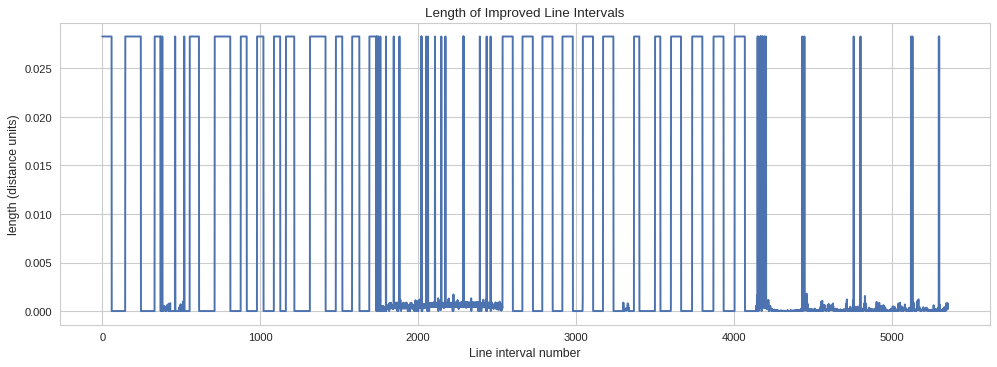

In [215]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([length(x) for x in lines_improved])
plt.ylabel('length (distance units)')
plt.xlabel('Line interval number')
plt.title('Length of Improved Line Intervals')
#plt.xlim(122,127)

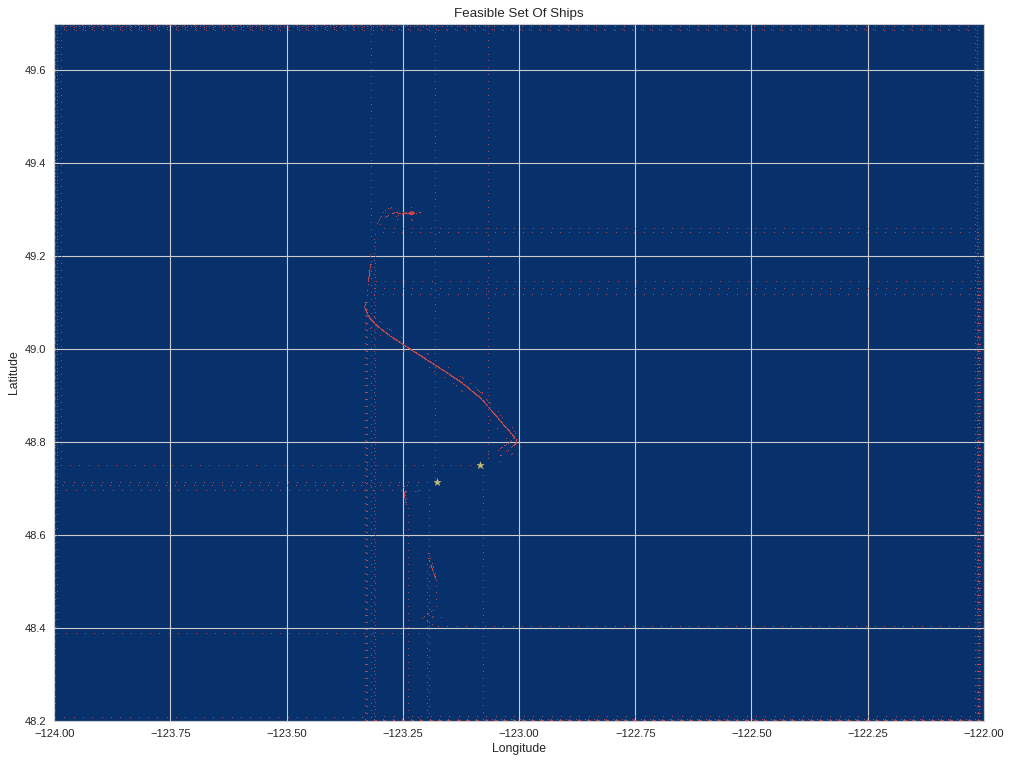

In [216]:
points_x2 = list(zip(*lines_improved))
points = points_x2[0]
l = list(zip(*points))
x = l[0]
y = l[1]

fig = plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Feasible Set Of Ships")
plt.imshow(H, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.Blues)

plt.scatter(x,y, marker='.', color='r', s=2)
l = lines[98]
x = [l[0][0], l[1][0]]
y = [l[0][1], l[1][1]]
plt.scatter(x,y, marker='*', color='y')